<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_Inverse_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Учим обратную матрицу

 Первый непрвильный способ - пусть сеть её выдаёт

In [ ]:
import torch
from torch import nn, optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import copy
from torch.optim.lr_scheduler import StepLR

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # для GPU отдельный seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(43)

# есть стохастические операции на GPU
# сделаем их детерминированными для воспроизводимости
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import torch
from torch.utils.data import Dataset

class InverseMatrixDataset(Dataset):
    def __init__(self, n, num_samples):
        """
        Инициализация обучающей выборки

        Args:
            n (int): Размер матрицы
            num_samples (int): Количество образцов данных
        """
        self.n = n
        self.num_samples = num_samples

    def __len__(self):
        """
        Возвращает общее количество образцов данных
        """
        return self.num_samples

    def __getitem__(self, idx):
        """
        Возвращает образец данных и соответствующую обратную матрицу

        Args:
            idx (int): Индекс образца данных

        Returns:
            torch.Tensor, torch.Tensor: Образец данных и соответствующая обратная матрица
        """
        matrix = torch.randn(self.n, self.n) # Генерируем случайную матрицу
        inverse_matrix = torch.inverse(matrix) # Вычисляем обратную матрицу

        matrix, inverse_matrix = matrix.reshape(-1), inverse_matrix.reshape(-1)

        return matrix, inverse_matrix # .view(-1).view(-1)

In [ ]:
import torch
from torch.utils.data import Dataset

class PowerMatrixDataset(Dataset):
    def __init__(self, n, num_samples):
        """
        Инициализация обучающей выборки

        Args:
            n (int): Размер матрицы
            num_samples (int): Количество образцов данных
        """
        self.n = n
        self.num_samples = num_samples

    def __len__(self):
        """
        Возвращает общее количество образцов данных
        """
        return self.num_samples

    def __getitem__(self, idx):
        """
        Возвращает образец данных и соответствующую обратную матрицу

        Args:
            idx (int): Индекс образца данных

        Returns:
            torch.Tensor, torch.Tensor: Образец данных и соответствующая обратная матрица
        """
        matrix = torch.randn(self.n, self.n) # Генерируем случайную матрицу
        power_matrix = matrix @ matrix # Вычисляем обратную матрицу

        matrix, power_matrix = matrix.reshape(-1), power_matrix.reshape(-1)

        return matrix, power_matrix # .view(-1).view(-1)

In [ ]:
data = InverseMatrixDataset(n=2, num_samples=3)
data[0]

(tensor([0.1876, 1.4748, 1.7583, 0.6546]),
 tensor([-0.2650,  0.5970,  0.7118, -0.0759]))

In [ ]:
torch.randn(2, 2) @ torch.randn(2, 2)

tensor([[ 1.2511, -0.3013],
        [-0.4765, -0.6543]])

In [ ]:
data[0][0]

tensor([ 2.6806,  1.2237, -0.9404,  0.3296])

In [ ]:
data[1][0]

tensor([-2.0612, -0.1613, -1.2114,  0.0114])

In [ ]:
model(data[0][0].view(1, -1))

tensor([[ 2.2531, -2.9721, -1.7303,  3.2184]], grad_fn=<AddmmBackward0>)

In [ ]:
model(data[0][1].view(1, -1))

tensor([[ 2.2531, -2.9721, -1.7303,  3.2184]], grad_fn=<AddmmBackward0>)

In [ ]:
loss(data[0][0].view(1, -1), data[1][0].view(1, -1))

tensor(0.5195)

In [ ]:
model(data[0][0].view(1, -1)), model(data[1][0].view(1, -1))

(tensor([[ 2.2531, -2.9721, -1.7303,  3.2184]], grad_fn=<AddmmBackward0>),
 tensor([[ 2.2531, -2.9721, -1.7303,  3.2184]], grad_fn=<AddmmBackward0>))

In [ ]:
def model_L_DN_F(n_input, width, nlayers):
  """
  сеть Linear + BN + ReLU
  """
  model = torch.nn.Sequential()
  model.add_module('L0', nn.Linear(n_input, width, bias=False))
  model.add_module('BN0',  nn.BatchNorm1d(width))
  for i in range(nlayers - 2):
    model.add_module('RELU' + str(i),  nn.ReLU())
    model.add_module('L'+str(i+1),  nn.Linear(width, width, bias=False)) # ДОБАВИЛ , bias=False
    model.add_module('BN'+str(i+1),  nn.BatchNorm1d(width))
  model.add_module('RELU' + str(nlayers - 2),  nn.ReLU())
  model.add_module('L' + str(nlayers - 1),  nn.Linear(width, n_input)) # РАЗМЕРЫ ВХОДА = ВЫХОДА
  return(model)

In [ ]:
class model_ResMy(nn.Module):
    def __init__(self, n_input, width, nlayers):
        super().__init__()
        self.lin0 = nn.Linear(n_input, width, bias=False)
        self.bn0 = nn.BatchNorm1d(width)

        self.hidden = []
        for i in range(nlayers - 2):
            self.hidden.append(nn.Sequential(nn.ReLU(),
                                             nn.Linear(width, width, bias=False),
                                             nn.BatchNorm1d(width)))

        self.hidden = nn.ModuleList(self.hidden)

        self.reluL = nn.ReLU()
        self.linL = nn.Linear(width, n_input)


    def forward(self, x):
        x = self.lin0(x)
        x = self.bn0(x)
        for h in self.hidden:
          x = x + h(x)
        x = self.reluL(x)
        x = self.linL(x)
        return x

In [ ]:
from torch.utils.data import DataLoader
import time

n = 2 # размеры матрицы
n_train = 1000
n_test = 10000
learning_rate = 0.1


#data_train = PowerMatrixDataset(n=n, num_samples=n_train)
#data_test = PowerMatrixDataset(n=n, num_samples=n_test)

data_train = InverseMatrixDataset(n=n, num_samples=n_train)
data_test = InverseMatrixDataset(n=n, num_samples=n_test)


#dataloader_train = DataLoader(data_train, batch_size = 128, shuffle=True) #, num_workers=10)
#dataloader_test = DataLoader(data_test, batch_size = 128, shuffle=False)

# model = model_L_DN_F(n_input=n*n, width=2*n*n, nlayers=10)
model = model_ResMy(n_input=n*n, width=2*n*n, nlayers=10)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#  torch.nn.MSELoss
loss = nn.MSELoss()

In [ ]:
model

model_ResMy(
  (lin0): Linear(in_features=4, out_features=8, bias=False)
  (bn0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden): ModuleList(
    (0-7): 8 x Sequential(
      (0): ReLU()
      (1): Linear(in_features=8, out_features=8, bias=False)
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (reluL): ReLU()
  (linL): Linear(in_features=8, out_features=4, bias=True)
)

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0

    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)   # .backward() accumulates gradients, это эквивалентно model.zero_grad()
        data = data.to(device)
        target = target.to(device) # перенос на device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()

    running_loss /= len(train_loader)
    #print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss, end_time - start_time

def test_model(model, test_loader, criterion):
    with torch.no_grad(): # не забывать делать это и на Inference
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            #_, predicted = torch.max(outputs.data, 1)
            #total_predictions += target.size(0)
            #correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        #acc = (correct_predictions/total_predictions)*100.0
        #print('Testing Loss: ', running_loss)
        #print('Testing Accuracy: ', acc, '%')
        return running_loss #, acc

In [ ]:
n_epochs = 100
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss, time_epoch = train_epoch(model, dataloader_train, criterion=loss, optimizer=optimizer)

    test_loss = test_model(model, dataloader_test, criterion=loss) # , test_acc
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    #Test_acc.append(test_acc)
    #print('='*20)
    print("[EXP]: %i, [TIME]: %.6f, [LOSS1]: %.6f, [LOSS2]: %.6f" % (i, time_epoch, train_loss, test_loss))
    display.clear_output(wait=True)

[EXP]: 99, [TIME]: 0.064796, [LOSS1]: 0.377834, [LOSS2]: 0.381201


(0.0, 4.0)

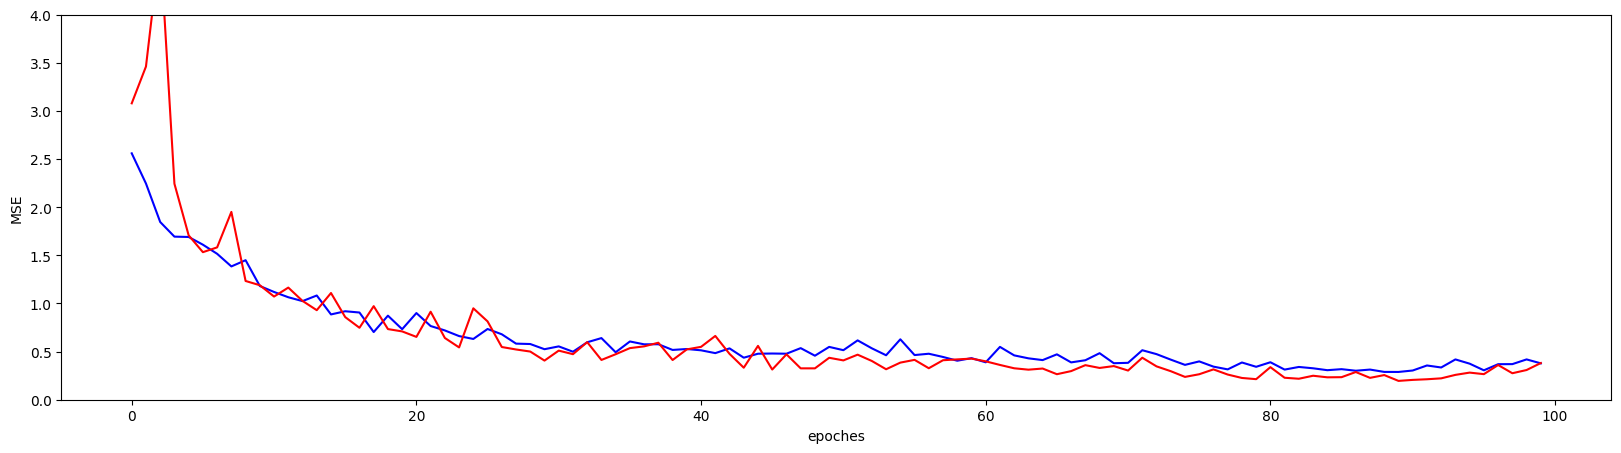

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(Train_loss, 'b-') # [:,100:]
plt.plot(Test_loss, 'r-') # [:,100:]
#plt.yscale('log')
plt.xlabel('epoches')
plt.ylabel('MSE')
plt.ylim([0, 4])

In [ ]:
# [EXP]: 99, [TIME]: 0.068750, [LOSS1]: 1.169050, [LOSS2]: 1.009273
# [EXP]: 99, [TIME]: 0.063184, [LOSS1]: 0.905618, [LOSS2]: 0.857002 (прокидываем связи)

inverse
# [EXP]: 99, [TIME]: 0.064796, [LOSS1]: 0.377834, [LOSS2]: 0.381201

Sequential(
  (L0): Linear(in_features=4, out_features=8, bias=False)
  (BN0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU0): ReLU()
  (L1): Linear(in_features=8, out_features=8, bias=False)
  (BN1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU1): ReLU()
  (L2): Linear(in_features=8, out_features=8, bias=False)
  (BN2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU2): ReLU()
  (L3): Linear(in_features=8, out_features=8, bias=False)
  (BN3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU3): ReLU()
  (L4): Linear(in_features=8, out_features=8, bias=False)
  (BN4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU4): ReLU()
  (L5): Linear(in_features=8, out_features=8, bias=False)
  (BN5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RELU5): ReLU()
  (L

In [ ]:

def train_model(data_train, model, optimizer, scheduler, n_epoches = 1000, m = 10000, device=device, use_scheduler=True):
  losses1 = np.zeros(n_epoches)
  losses2 = np.zeros(n_epoches)

  for t in range(n_epoches):
    # обучение
    # небольшой датасет - сразу по всему!
    # X_train, y_train = makeXtrain(m=m, device=device)

    model.train()
    a_train = model(X_train)
    loss = criterion(a_train, y_train)
    optimizer.zero_grad(set_to_none=True) # обнулить градиент ###
    loss.backward()  # обратный проход
    optimizer.step() # поправка весов

    if use_scheduler:
      scheduler.step() # поправка LR

    model.eval() ####
    with torch.no_grad():
        a_test = model(X_test)
        test_loss = criterion(a_test, y_test)

    losses1[t] = loss.item() / (criterion(y_train, y_train*0 + y_train.mean()).item()) # НОРМИРОВКА
    losses2[t] = test_loss.item() / (criterion(y_test, y_test*0 + y_test.mean()).item()) # НОРМИРОВКА
    #print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f" % (t, losses1[t], losses2[t]))

  return losses1, losses2

In [ ]:
%%time

n_epoches = 1000

losses1 = np.zeros(n_epoches)
losses2 = np.zeros(n_epoches)
lrs = np.zeros(n_epoches)

set_seed(43)
# контроль
X_test, y_test = makeXtrain(m=m, n0=n0, device=device)


# X_train, y_train = makeXtrain(m=m, n0=n0, device=device) # ПЕРЕНЁС СЮДА - ВЕРНУТЬ!!!!!!

for t in range(n_epoches):
    # обучение
    # небольшой датасет - сразу по всему!
    X_train, y_train = makeXtrain(m=m, n0=n0, device=device)

    model.train()
    a_train = model(X_train)
    loss = criterion(a_train, y_train)
    optimizer.zero_grad() # обнулить градиент
    loss.backward()  # обратный проход
    optimizer.step() # поправка весов

    if use_scheduler:
      scheduler.step() # поправка LR

    model.eval()
    with torch.no_grad():
        a_test = model(X_test)
        test_loss = criterion(a_test, y_test)

        if t==5:
          # сохранить некоторые чекпоинты
          model1 = copy.deepcopy(model)
        elif t==100:
          model2 = copy.deepcopy(model)

        #w_norm = []
        #g_norm = []
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        w_norm.append(param.data.norm().item())
        #        g_norm.append(param.grad.data.norm().item())

    losses1[t] = loss.item()
    losses2[t] = test_loss.item()
    lrs[t] = optimizer.param_groups[0]['lr']
    print("[EPOCH]: %i, [LOSS]: %.6f, [LOSS2]: %.6f, [LR]: %.6f" % (t, losses1[t], losses2[t], lrs[t]))

    display.clear_output(wait=True)